In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier


In [2]:
# 1. Read Data
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
          'marital-status', 'occupation', 'relationship', 'race', 'sex',
          'capital-gain', 'capital-loss', 'hours-per-week',
          'native-country', 'label']
df = pd.read_csv('./train.csv', header=None, names=header)
df_final = pd.read_csv('./test.csv', header=None, names=header)


In [3]:
# 2. Preprocessing
nominal = [1, 3, 5, 6, 7, 8, 9, 13]
notnominal = [i for i in range(15) if i not in nominal]
X = df.iloc[:, :14].values
X_final = df_final.iloc[:, :14].values
for i in nominal:
    le = LabelEncoder()
    X[:, i] = le.fit_transform(X[:, i])
    X_final[:, i] = le.transform(X_final[:, i])
y = df.iloc[:, 14].values
df_nominal = df.iloc[:, nominal].apply(LabelEncoder().fit_transform)
df2 = pd.DataFrame.join(df_nominal, df.iloc[:, notnominal])


In [4]:
# 3. Random Forest for feature selection
tree = RandomForestClassifier(n_estimators=10000,
                              random_state=0,
                              n_jobs=-1)
feat_labels = df.columns[:14]
tree.fit(X, y)
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" %
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))



 1) fnlwgt                         0.177078
 2) age                            0.150813
 3) capital-gain                   0.111413
 4) relationship                   0.103351
 5) education-num                  0.089466
 6) hours-per-week                 0.082482
 7) marital-status                 0.070071
 8) occupation                     0.066186
 9) workclass                      0.038016
10) capital-loss                   0.037469
11) education                      0.032379
12) native-country                 0.015251
13) race                           0.014103
14) sex                            0.011924


In [5]:
# 4.1.
# modelfit function from
# https://blog.csdn.net/han_xiaoyang/article/details/52665396
# use for optimizing estimators
def modelfit(alg, df, predictors, useTrainCV=True,
             cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgbtrain = xgb.DMatrix(df[predictors].values,
                               label=df['label'].values)
        cvresult = xgb.cv(xgb_param,
                          xgbtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(df[predictors], df['label'], eval_metric='error')
    pred = alg.predict(df[predictors])
    predprob = alg.predict_proba(df[predictors])[:, 1]
    print('\nModel Report')
    print('estimators: %d' % cvresult.shape[0])
    print('f1:%.4g' % metrics.f1_score(df['label'], pred, average='weighted'))
    print('Accuracy:%.4g' % metrics.accuracy_score(df['label'], pred))
    print('AUC(train):%f' % metrics.roc_auc_score(df['label'], predprob))
    feat_imp = pd.Series(
        alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='feature importances')
    plt.ylabel('fm_score')




Model Report
estimators: 193
f1:0.8802
Accuracy:0.8837
AUC(train):0.942996


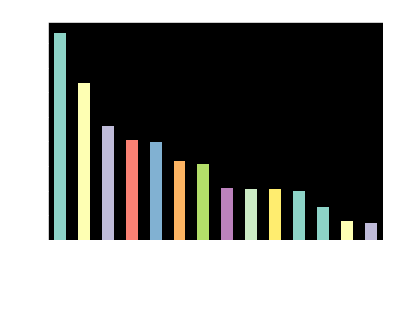

In [6]:
# 4.2. tuning parameters
predictors = [x for x in df.columns if x not in ['label']]
clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1)
modelfit(clf, df2, predictors, cv_folds=10)


In [7]:
clf.set_params(n_estimators=193)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=193,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [8]:
param1 = {'max_depth': range(3, 12, 2),
          'min_child_weight': range(1, 6, 2)}
gs1 = GridSearchCV(
    estimator=clf,
    param_grid=param1,
    scoring='f1_weighted',
    n_jobs=-1,
    iid=False,
    cv=10)
gs1.fit(X, y)
print(gs1.best_params_)
print(gs1.best_score_)


{'max_depth': 7, 'min_child_weight': 1}
0.8636945358916789


In [9]:
clf.set_params(max_depth=7, min_child_weight=1)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=193,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [10]:
param2 = {'max_depth': [6, 7, 8],
          'min_child_weight': [0, 1]}
gs2 = GridSearchCV(
    estimator=clf,
    param_grid=param2,
    scoring='f1_weighted',
    n_jobs=-1,
    iid=False,
    cv=10)
gs2.fit(X, y)
print(gs2.best_params_)
print(gs2.best_score_)


{'max_depth': 7, 'min_child_weight': 0}
0.8648447802792646


In [11]:
clf.set_params(min_child_weight=0)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=0, missing=None, n_estimators=193,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [12]:
param3 = {'gamma': np.arange(0, 5.1, 0.5)}
gs3 = GridSearchCV(
    estimator=clf,
    param_grid=param3,
    scoring='f1_weighted',
    n_jobs=-1,
    iid=False,
    cv=10)
gs3.fit(X, y)
print(gs3.best_params_)
print(gs3.best_score_)


{'gamma': 4.0}
0.8659206524366556


In [13]:
clf.set_params(gamma=4.0)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=4.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=0, missing=None,
       n_estimators=193, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [14]:
param4 = {'subsample': [i / 10. for i in range(5, 11)],
          'colsample_bytree': [i / 10. for i in range(5, 11)]}
gs4 = GridSearchCV(
    estimator=clf,
    param_grid=param4,
    scoring='f1_weighted',
    n_jobs=-1,
    iid=False,
    cv=10)
gs4.fit(X, y)
print(gs4.best_params_)
print(gs4.best_score_)


{'subsample': 0.8, 'colsample_bytree': 0.8}
0.8659206524366556


In [15]:
param5 = {'subsample': [0.75, 0.8, 0.85],
          'colsample_bytree': [0.75, 0.8, 0.85]}
gs5 = GridSearchCV(
    estimator=clf,
    param_grid=param5,
    scoring='f1_weighted',
    n_jobs=-1,
    iid=False,
    cv=10)
gs5.fit(X, y)
print(gs5.best_params_)
print(gs5.best_score_)


{'subsample': 0.8, 'colsample_bytree': 0.8}
0.8659206524366556


In [16]:
clf.set_params(colsample_bytree=0.8, subsample=0.8)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=4.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=0, missing=None,
       n_estimators=193, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)


Model Report
estimators: 713
f1:0.8732
Accuracy:0.8775
AUC(train):0.935459


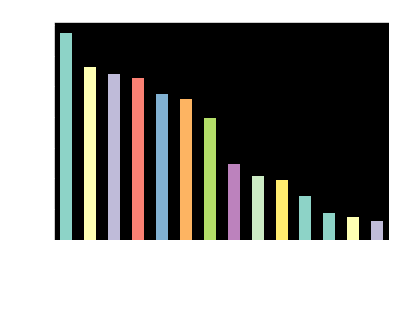

In [17]:
clf.set_params(learning_rate=0.01, n_estimators=5000)
modelfit(clf, df2, predictors, cv_folds=10)


In [18]:
clf.set_params(n_estimators=713)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=4.0, learning_rate=0.01,
       max_delta_step=0, max_depth=7, min_child_weight=0, missing=None,
       n_estimators=713, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [19]:
# 713 not improve
clf.set_params(learning_rate=0.1, n_estimators=193)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=4.0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=0, missing=None,
       n_estimators=193, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [20]:
# f1 evaluation
scores = cross_val_score(clf, X, y, scoring='f1_weighted', cv=10, n_jobs=-1)
print('f1: %.4f +/- %.4f' % (np.mean(scores), np.std(scores)))


f1: 0.8659 +/- 0.0077


In [21]:
# 4.3 tuning result
clf = XGBClassifier(
    learning_rate=0.1,
    n_estimators=193,
    max_depth=7,
    min_child_weight=0,
    gamma=4.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1)


In [22]:
# 5. Predict test.csv
clf.fit(X, y)
y_final = clf.predict(X_final)
answer = pd.DataFrame()
answer['ID'] = range(len(y_final))
answer['ans'] = y_final.flatten().astype(int)
answer.to_csv('answer.csv', index=False)
